# 09 – Operational Decision Support and Uncertainty

In this notebook, we move beyond raw accuracy and focus on how the model would
behave in a real Security Operations Center (SOC). Specifically, we:

- Introduce simple uncertainty measures (maximum predicted probability, entropy).
- Add an explicit **"uncertain"** bucket when the model is not confident.
- Quantify how often the model is confident enough to auto-triage versus when
  it should defer to a human analyst.
- Walk through a few SOC-style example narratives and show how the model's
  predictions and uncertainty scores could be used in practice.

The goal is not to chase perfect accuracy, but to frame the classifier as a
**decision-support tool** that knows when to act and when to ask for help.

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath("../src"))
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("default")
sns.set_theme()

# --- Load artifacts from previous notebooks ---
print("---Loading model artifacts and test data---")

vectorizer = joblib.load("../models/vectorizer.joblib")
clf = joblib.load("../models/baseline_logreg.joblib")

X_test = joblib.load("../models/X_test_tfidf.joblib")
y_test = joblib.load("../models/y_test.joblib")

print("X_test shape:", X_test.shape)
print("Number of test labels:", len(y_test))
print("\nUnique labels in test set:", set(y_test))
print("Class distribution:", y_test.value_counts().to_dict())

---Loading model artifacts and test data---
X_test shape: (150000, 5000)
Number of test labels: 150000

Unique labels in test set: {'data_exfiltration', 'policy_violation', 'access_abuse', 'web_attack', 'benign_activity', 'phishing', 'suspicious_network_activity', 'credential_compromise', 'insider_threat', 'malware'}
Class distribution: {'policy_violation': 16817, 'insider_threat': 15579, 'access_abuse': 15517, 'data_exfiltration': 15070, 'benign_activity': 15069, 'web_attack': 15031, 'suspicious_network_activity': 14970, 'credential_compromise': 14337, 'phishing': 13860, 'malware': 13750}


In [2]:
print("\n---Baseline performance recap (no uncertainty handling)---")
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


---Baseline performance recap (no uncertainty handling)---
                             precision    recall  f1-score   support

               access_abuse       0.92      0.88      0.90     15517
            benign_activity       0.92      0.92      0.92     15069
      credential_compromise       0.92      0.96      0.94     14337
          data_exfiltration       0.92      0.92      0.92     15070
             insider_threat       0.92      0.88      0.90     15579
                    malware       0.92      1.00      0.96     13750
                   phishing       0.92      1.00      0.96     13860
           policy_violation       0.92      0.82      0.87     16817
suspicious_network_activity       0.92      0.93      0.92     14970
                 web_attack       0.92      0.92      0.92     15031

                   accuracy                           0.92    150000
                  macro avg       0.92      0.92      0.92    150000
               weighted avg       0.92   

In [3]:
from scipy.stats import entropy

if not hasattr(clf, "predict_proba"):
    raise RuntimeError("This notebook assumes the classifier supports predict_proba.")

proba = clf.predict_proba(X_test)  # shape: (n_samples, n_classes)
class_labels = clf.classes_

# Max probability per sample
max_prob = proba.max(axis=1)

# Entropy per sample (base 2 for interpretability)
ent = entropy(proba.T, base=2)

uncertainty_df = pd.DataFrame({
    "true": y_test.reset_index(drop=True),
    "pred": y_pred,
    "max_prob": max_prob,
    "entropy": ent,
})

uncertainty_df.head()

,true,pred,max_prob,entropy
0,credential_compromise,credential_compromise,0.577489,1.424045
1,insider_threat,insider_threat,0.652509,1.274959
2,policy_violation,policy_violation,0.741433,1.105943
3,insider_threat,insider_threat,0.839397,0.824273
4,malware,malware,0.709888,0.895924


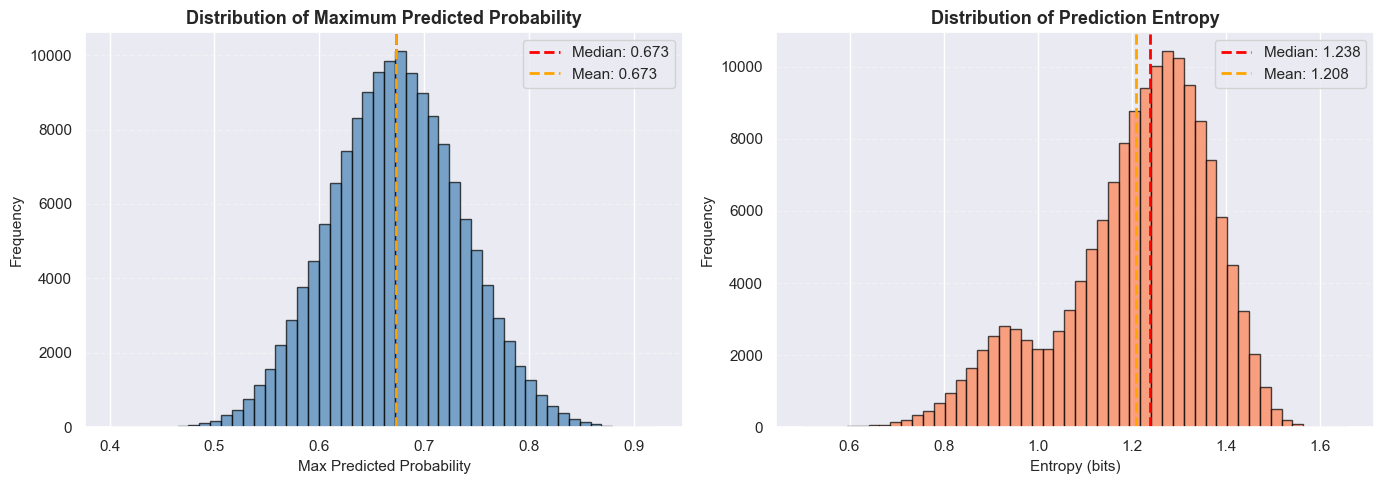


--- Uncertainty Statistics ---
Max Probability - Mean: 0.6733, Median: 0.6731
Max Probability - Min: 0.4027, Max: 0.9210

Entropy - Mean: 1.2081, Median: 1.2375
Entropy - Min: 0.5020, Max: 1.6563


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Maximum probability distribution
ax1.hist(uncertainty_df["max_prob"], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(uncertainty_df["max_prob"].median(), color='red', linestyle='--', linewidth=2, 
            label=f'Median: {uncertainty_df["max_prob"].median():.3f}')
ax1.axvline(uncertainty_df["max_prob"].mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {uncertainty_df["max_prob"].mean():.3f}')
ax1.set_title("Distribution of Maximum Predicted Probability", fontsize=13, fontweight='bold')
ax1.set_xlabel("Max Predicted Probability", fontsize=11)
ax1.set_ylabel("Frequency", fontsize=11)
ax1.grid(axis="y", alpha=0.3, linestyle='--')
ax1.legend()

# Plot 2: Entropy distribution
ax2.hist(uncertainty_df["entropy"], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(uncertainty_df["entropy"].median(), color='red', linestyle='--', linewidth=2,
            label=f'Median: {uncertainty_df["entropy"].median():.3f}')
ax2.axvline(uncertainty_df["entropy"].mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {uncertainty_df["entropy"].mean():.3f}')
ax2.set_title("Distribution of Prediction Entropy", fontsize=13, fontweight='bold')
ax2.set_xlabel("Entropy (bits)", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.grid(axis="y", alpha=0.3, linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n--- Uncertainty Statistics ---")
print(f"Max Probability - Mean: {uncertainty_df['max_prob'].mean():.4f}, Median: {uncertainty_df['max_prob'].median():.4f}")
print(f"Max Probability - Min: {uncertainty_df['max_prob'].min():.4f}, Max: {uncertainty_df['max_prob'].max():.4f}")
print(f"\nEntropy - Mean: {uncertainty_df['entropy'].mean():.4f}, Median: {uncertainty_df['entropy'].median():.4f}")
print(f"Entropy - Min: {uncertainty_df['entropy'].min():.4f}, Max: {uncertainty_df['entropy'].max():.4f}")

In [5]:
def apply_uncertainty_threshold(
    proba: np.ndarray,
    base_predictions: np.ndarray,
    true_labels: pd.Series,
    threshold: float = 0.50,
    uncertain_label: str = "uncertain",
):
    """
    Given predicted probabilities and base predictions, return:
    - final_preds: where low-confidence samples are mapped to 'uncertain'
    - metrics: dict with counts and coverage
    """
    max_prob = proba.max(axis=1)
    is_uncertain = max_prob < threshold

    final_preds = base_predictions.copy().astype(object)
    final_preds[is_uncertain] = uncertain_label

    df = pd.DataFrame({
        "true": true_labels.reset_index(drop=True),
        "base_pred": base_predictions,
        "final_pred": final_preds,
        "max_prob": max_prob,
        "is_uncertain": is_uncertain,
    })

    total = len(df)
    n_uncertain = df["is_uncertain"].sum()
    coverage = 1.0 - n_uncertain / total

    # Accuracy on confident subset only
    confident = df[~df["is_uncertain"]]
    if len(confident) > 0:
        confident_acc = np.mean(confident["true"] == confident["final_pred"])
    else:
        confident_acc = np.nan

    metrics = {
        "threshold": threshold,
        "total_samples": total,
        "n_uncertain": int(n_uncertain),
        "coverage": coverage,
        "confident_accuracy": confident_acc,
    }

    return df, metrics


threshold = 0.50
final_df, metrics = apply_uncertainty_threshold(
    proba, y_pred, y_test, threshold=threshold
)

print(f"--- Uncertainty threshold = {threshold:.2f} ---")
print(f"Total samples: {metrics['total_samples']}")
print(f"Marked as 'uncertain': {metrics['n_uncertain']} "
      f"({1 - metrics['coverage']:.1%} of all cases)")
print(f"Coverage (auto-triaged by model): {metrics['coverage']:.1%}")
print(f"Accuracy on confident subset: {metrics['confident_accuracy']:.4f}")

--- Uncertainty threshold = 0.50 ---
Total samples: 150000
Marked as 'uncertain': 270 (0.2% of all cases)
Coverage (auto-triaged by model): 99.8%
Accuracy on confident subset: 0.9196


In [6]:
thresholds = [0.40, 0.50, 0.60, 0.70]
rows = []

for th in thresholds:
    _, m = apply_uncertainty_threshold(proba, y_pred, y_test, threshold=th)
    rows.append(m)

th_df = pd.DataFrame(rows)
th_df

,threshold,total_samples,n_uncertain,coverage,confident_accuracy
0,0.4,150000,0,1.000000,0.919593
1,0.5,150000,270,0.998200,0.919569
2,0.6,150000,18123,0.879180,0.919759
3,0.7,150000,99856,0.334293,0.920509


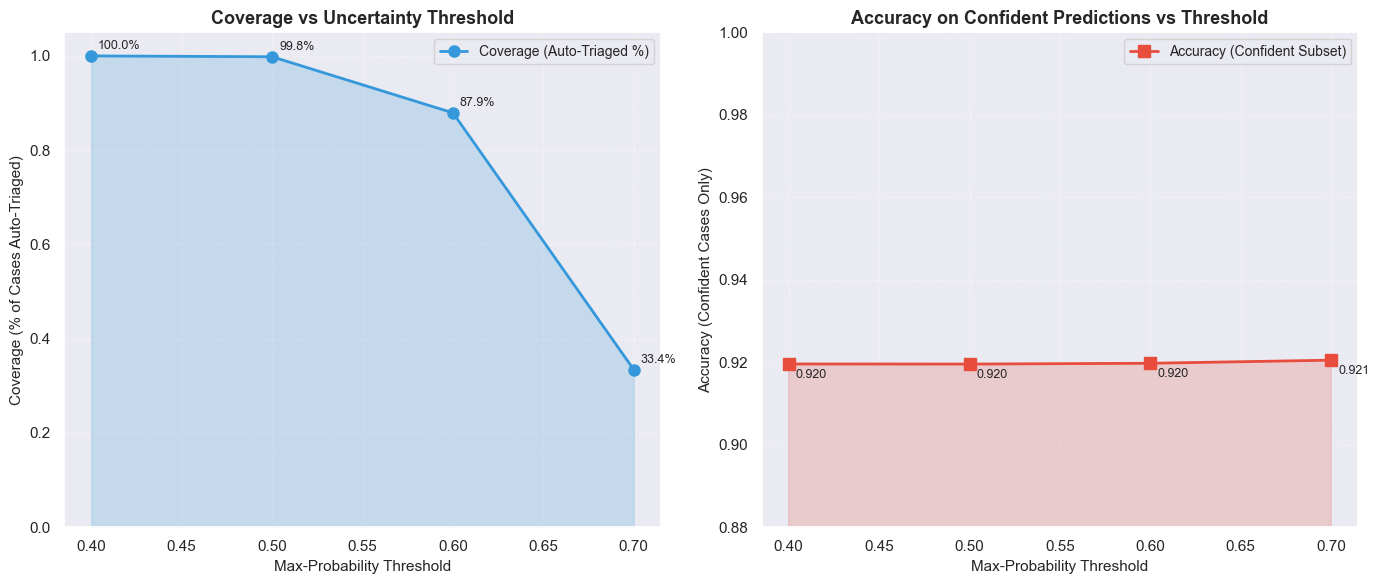

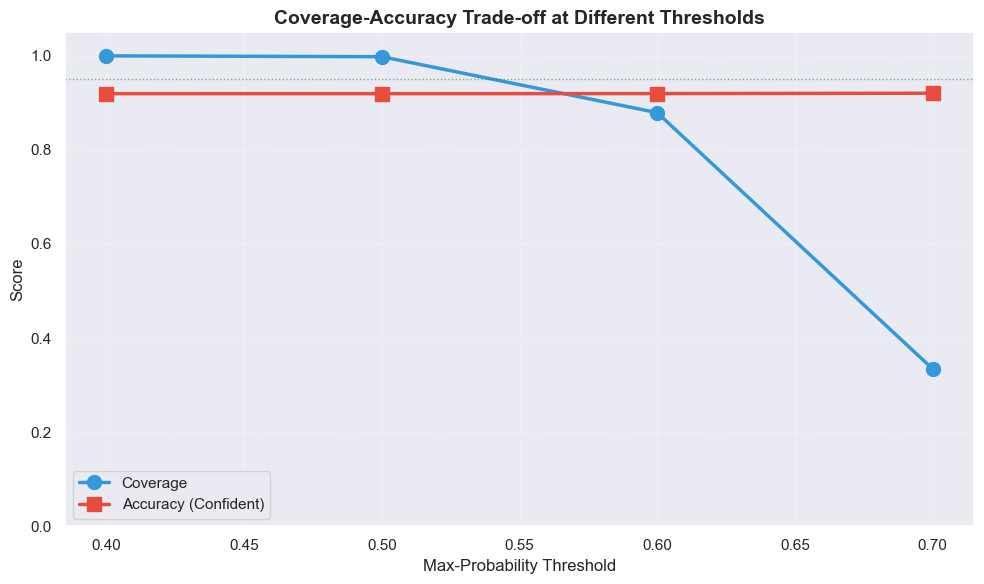


--- Threshold Trade-off Summary ---


,threshold,total_samples,n_uncertain,coverage,confident_accuracy
0,0.4,150000,0,1.000000,0.919593
1,0.5,150000,270,0.998200,0.919569
2,0.6,150000,18123,0.879180,0.919759
3,0.7,150000,99856,0.334293,0.920509


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Coverage vs Threshold
ax1.plot(th_df["threshold"], th_df["coverage"], marker="o", linewidth=2, 
         markersize=8, color='#3498db', label="Coverage (Auto-Triaged %)")
ax1.fill_between(th_df["threshold"], 0, th_df["coverage"], alpha=0.2, color='#3498db')
ax1.set_title("Coverage vs Uncertainty Threshold", fontsize=13, fontweight='bold')
ax1.set_xlabel("Max-Probability Threshold", fontsize=11)
ax1.set_ylabel("Coverage (% of Cases Auto-Triaged)", fontsize=11)
ax1.set_ylim(0.0, 1.05)
ax1.grid(alpha=0.3, linestyle='--')
ax1.legend(fontsize=10)

# Annotate points
for i, row in th_df.iterrows():
    ax1.annotate(f'{row["coverage"]:.1%}', 
                xy=(row["threshold"], row["coverage"]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot 2: Accuracy on confident subset vs Threshold  
ax2.plot(th_df["threshold"], th_df["confident_accuracy"], marker="s", linewidth=2,
         markersize=8, color='#e74c3c', label="Accuracy (Confident Subset)")
ax2.fill_between(th_df["threshold"], 0, th_df["confident_accuracy"], alpha=0.2, color='#e74c3c')
ax2.set_title("Accuracy on Confident Predictions vs Threshold", fontsize=13, fontweight='bold')
ax2.set_xlabel("Max-Probability Threshold", fontsize=11)
ax2.set_ylabel("Accuracy (Confident Cases Only)", fontsize=11)
ax2.set_ylim(0.88, 1.0)
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(fontsize=10)

# Annotate points
for i, row in th_df.iterrows():
    ax2.annotate(f'{row["confident_accuracy"]:.3f}', 
                xy=(row["threshold"], row["confident_accuracy"]),
                xytext=(5, -10), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# Combined plot: Coverage vs Accuracy Trade-off
plt.figure(figsize=(10, 6))
plt.plot(th_df["threshold"], th_df["coverage"], marker="o", linewidth=2.5, 
         markersize=10, color='#3498db', label="Coverage")
plt.plot(th_df["threshold"], th_df["confident_accuracy"], marker="s", linewidth=2.5,
         markersize=10, color='#e74c3c', label="Accuracy (Confident)")
plt.title("Coverage-Accuracy Trade-off at Different Thresholds", fontsize=14, fontweight='bold')
plt.xlabel("Max-Probability Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0.0, 1.05)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='best')
plt.axhline(y=0.95, color='green', linestyle=':', linewidth=1, alpha=0.5, label='95% target')
plt.tight_layout()
plt.show()

# Print summary table
print("\n--- Threshold Trade-off Summary ---")
display(th_df)

In [8]:
# Misclassified in the baseline prediction
baseline_errors = uncertainty_df[uncertainty_df["true"] != uncertainty_df["pred"]]

print(f"Baseline misclassifications (no uncertainty handling): {len(baseline_errors)}")

# Among those, which got marked as 'uncertain' at current threshold?
error_join = baseline_errors.join(
    final_df[["final_pred", "is_uncertain"]],
    how="left"
)

flagged_uncertain = error_join[error_join["is_uncertain"]]
print(f"Errors caught by 'uncertain' bucket at threshold={threshold:.2f}: "
      f"{len(flagged_uncertain)}")

flagged_uncertain.head(10)

Baseline misclassifications (no uncertainty handling): 12061
Errors caught by 'uncertain' bucket at threshold=0.50: 18


,true,pred,max_prob,entropy,final_pred,is_uncertain
13223,access_abuse,credential_compromise,0.476988,1.550700,uncertain,True
13467,insider_threat,credential_compromise,0.464116,1.531551,uncertain,True
15701,policy_violation,benign_activity,0.497062,1.522371,uncertain,True
18524,data_exfiltration,insider_threat,0.495399,1.528638,uncertain,True
26661,suspicious_network_activity,benign_activity,0.487694,1.509521,uncertain,True
64785,access_abuse,credential_compromise,0.495509,1.535993,uncertain,True
77018,insider_threat,credential_compromise,0.485815,1.541095,uncertain,True
84306,access_abuse,credential_compromise,0.495051,1.524141,uncertain,True
93338,benign_activity,phishing,0.497665,1.517822,uncertain,True
121344,data_exfiltration,insider_threat,0.471083,1.536460,uncertain,True


In [9]:
def predict_with_uncertainty(text: str, threshold: float = 0.50):
    """
    Helper that:
    - cleans and vectorizes input
    - gets probabilities
    - applies uncertainty threshold
    - returns a dict with everything needed for display
    """
    from triage.preprocess import clean_description
    

    cleaned = clean_description(text)
    X_vec = vectorizer.transform([cleaned])

    proba_row = clf.predict_proba(X_vec)[0]
    max_p = proba_row.max()
    pred_idx = proba_row.argmax()
    base_label = class_labels[pred_idx]

    if max_p < threshold:
        final_label = "uncertain"
    else:
        final_label = base_label

    # Sort probabilities
    probs_sorted = sorted(
        zip(class_labels, proba_row),
        key=lambda x: x[1],
        reverse=True
    )

    return {
        "raw_text": text,
        "cleaned_text": cleaned,
        "base_label": base_label,
        "final_label": final_label,
        "max_prob": max_p,
        "probs_sorted": probs_sorted,
        "threshold": threshold,
    }


def pretty_print_decision(result: dict, top_k: int = 5):
    print("\n--- Incident Triage (with Uncertainty) ---")
    print("Input description:")
    print(result["raw_text"])
    print("\nCleaned text:")
    print(result["cleaned_text"])
    print("\nBase predicted event_type:", result["base_label"])
    print("Final event_type (with uncertainty):", result["final_label"])
    print(f"Max predicted probability: {result['max_prob']:.3f} "
          f"(threshold={result['threshold']:.2f})")

    print("\nTop class probabilities:")
    for cls, p in result["probs_sorted"][:top_k]:
        print(f"  {cls}: {p:.3f}")

In [10]:
examples = [
    "An employee reported that SERVER-BKUP-03 files are encrypted and they need a recovery key",
    "An employee reportedly downloaded a 30GB of files from Box and uploaded them to their personal google drive.",
    "Customers are reporting that the website is slow, but monitoring dashboards show no signs of attack traffic.",
    "User received an email about mandatory security training with a link to a non-corporate login page.",
]

for text in examples:
    res = predict_with_uncertainty(text, threshold=0.50)
    pretty_print_decision(res, top_k=5)
    print("\n" + "=" * 80)


--- Incident Triage (with Uncertainty) ---
Input description:
An employee reported that SERVER-BKUP-03 files are encrypted and they need a recovery key

Cleaned text:
an employee reported that server bkup files are encrypted and they need a recovery key

Base predicted event_type: policy_violation
Final event_type (with uncertainty): uncertain
Max predicted probability: 0.475 (threshold=0.50)

Top class probabilities:
  policy_violation: 0.475
  malware: 0.149
  benign_activity: 0.125
  insider_threat: 0.086
  data_exfiltration: 0.078


--- Incident Triage (with Uncertainty) ---
Input description:
An employee reportedly downloaded a 30GB of files from Box and uploaded them to their personal google drive.

Cleaned text:
an employee reportedly downloaded a 30gb of files from box and uploaded them to their personal googledrive

Base predicted event_type: data_exfiltration
Final event_type (with uncertainty): uncertain
Max predicted probability: 0.473 (threshold=0.50)

Top class probabili

## 9.1 Discussion: Uncertainty and SOC Decision Support

The experiments in this notebook illustrate that raw accuracy on a synthetic
hold-out set is only one dimension of model quality. In an operational SOC,
it is often more important for a classifier to:

1. Produce **high-confidence predictions** on clear-cut cases (e.g., obvious
   phishing, ransomware, or bulk exfiltration), and
2. Explicitly admit uncertainty on ambiguous narratives so that a human analyst
   can investigate further.

By introducing a simple **max-probability threshold** and an explicit
`"uncertain"` bucket, we can tune the trade-off between:

- **Coverage** – the fraction of alerts the model auto-triages, and  
- **Confident accuracy** – how often the model is correct on the subset of
  alerts it handles without deferral.

Even with a relatively modest threshold, the model is able to auto-classify
a large portion of the test set while catching a non-trivial number of its
own mistakes in the `"uncertain"` category. This behavior is much closer to
how a real SOC would use such a system: as a **decision-support tool** that
prioritizes and routes alerts, rather than as a fully autonomous classifier.

In a production setting, the uncertainty signal could drive:

- **Queue routing:** low-risk, high-confidence phishing into an automated
  remediation workflow; high-uncertainty cases into a senior analyst queue.
- **Dynamic thresholds:** more conservative thresholds for high-impact classes
  (e.g., `data_exfiltration`, `malware`) than for benign or low-severity
  categories.
- **Feedback loops:** analysts could label `"uncertain"` cases and feed them
  back into the training set, gradually improving performance on edge cases.

This notebook therefore closes the loop between model metrics and operational
usage, and sets the stage for future work such as calibration, cost-sensitive
learning, and integration with real incident data.